In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import os
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits

#filepath1 = '/home/patricia/Downloads/ngc1333_12co.fits'
#filepath2 = '/home/patricia/Downloads/ngc1333_13co.fits'
#filepath3 = '/home/patricia/Downloads/ngc1333_c18o.fits'

filepath1 = 'ngc1333_12co.fits'
filepath2 = 'ngc1333_13co.fits'
filepath3 = 'ngc1333_c18o.fits'


hdul1 = fits.open(filepath1)  # open a FITS file
hdul2 = fits.open(filepath2)
hdul3 = fits.open(filepath3)

data1 = hdul1[0].data  # assume the first extension is a table
data2 = hdul2[0].data
data3 = hdul3[0].data

hdul1.close(filepath1)
hdul2.close(filepath2)
hdul3.close(filepath3)


'''
print(repr(hdul1[0].header))
print(repr(hdul2[0].header))
print(repr(hdul3[0].header))
'''

'\nprint(repr(hdul1[0].header))\nprint(repr(hdul2[0].header))\nprint(repr(hdul3[0].header))\n'

Problem 1a

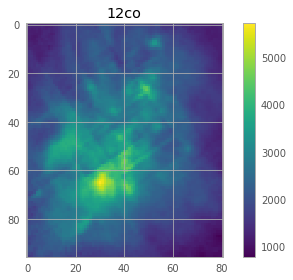

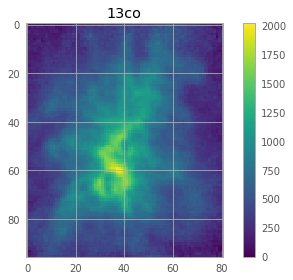

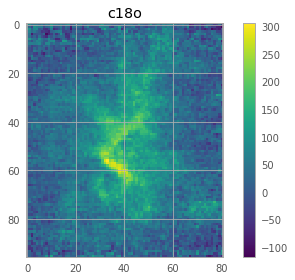

In [101]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
%matplotlib inline

#Define some constants
nu_12 = 115.271 * 1e9 #Hz
nu_13 = 110.201 * 1e9 #Hz
nu_18 = 109.782 * 1e9 #Hz
c = 3e10 #cm/s
k = 1.38e-16 #ergK^-1

velocities = np.arange(-9.99541, 29.995, 0.133)
lower = np.argwhere(velocities > 3.5)
upper = np.argwhere(velocities < 12.0)

truncated_data = [data1[lower.min():upper.max()+1,:,:] * 2, 
                  data2[lower.min():upper.max()+1,:,:] * 2, 
                  data3[lower.min():upper.max()+1,:,:] * 2]

intensities = []

for dataset in truncated_data:
    intensity = np.zeros_like(dataset)
    for z in range(len(dataset)):
        v_index = z + lower.min()
        intensity[z] = dataset[z] * (velocities[v_index])
    intensities.append(intensity)

summed_intensities = [np.sum(intensities[0], axis = 0),
                      np.sum(intensities[1], axis = 0),
                      np.sum(intensities[2], axis = 0)]

plt.figure()
plt.imshow(summed_intensities[0], cmap='viridis')
plt.title('12co')
plt.tight_layout()
plt.colorbar()

plt.figure()
plt.imshow(summed_intensities[1], cmap='viridis')
plt.title('13co')
plt.tight_layout()
plt.colorbar()

plt.figure()
plt.imshow(summed_intensities[2], cmap='viridis')
plt.title('c18o')
plt.tight_layout()
plt.colorbar()


Problem 1b

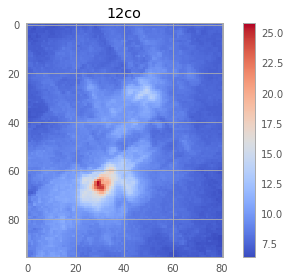

In [117]:
#list of three arrays of 96x81 one for each species
peak_emissions = []

for dataset in truncated_data:
    peaks = np.zeros_like(dataset[0])
    for y in range(len(dataset[0])):
        for x in range(len(dataset[0][0])):
            peaks[y,x] = dataset[:,y,x].max()
    peak_emissions.append(peaks)

def T_exc(T_B):
    T = 5.5 / math.log(1 + (5.5 / (T_B + 0.82)))
    return T

CO_12_Texc_peak = np.zeros_like(truncated_data[0][0])

for y in range(len(CO_12_Texc_peak)):
    for x in range(len(CO_12_Texc_peak[0])):
        brightnessTemp12 = peak_emissions[0][y,x]/2
        excit_temp12 = T_exc(brightnessTemp12)
        CO_12_Texc_peak[y,x] = excit_temp12
            
plt.figure()
plt.imshow(CO_12_Texc_peak, cmap='coolwarm')
#hot, redblue
plt.title('12co')
plt.tight_layout()
plt.colorbar()

Problem 2c

In [124]:
#einstein coefficients
A12 = 7.4e-8 #s^-1
A13 = 6.5e-8
A18 = 6.5e-8
T_cmb = 2.7 #K
dv = 0.133 #km/s
B12 = nu_12/2
B13 = nu_13/2
B18 = nu_18/2

h = 6.626e-27
A = 25**2 #pixels are 25 by 25 arcseconds
d = 280 #pc

m_neutron = 1.008664 #AMU
m_proton = 1.00727647 #AMU
AMU = 1.660540e-27 #kg
m12 = ((6*m_neutron) + (6*m_proton) + (8*m_neutron) + (8*m_proton)) * AMU
m13 = ((7*m_neutron) + (6*m_proton) + (8*m_neutron) + (8*m_proton)) * AMU
m18 = ((6*m_neutron) + (6*m_proton) + (10*m_neutron) + (8*m_proton)) * AMU

T_012 = h * nu_12 / k
T_013 = h * nu_13 / k
T_018 = h * nu_18 / k

def N_J (J, T_0, nu, A_J, T_mb, T_ex, dv):
    col_dens = 93.28 * ((2*J + 1) / (2*J + 3)) * (nu**3 / A_J) * ((T_mb * dv) 
                                                                / ( (1 - math.exp(-T_0/T_ex)) * T_0 
                                                                   * ( ((math.exp(T_0/T_ex) - 1)**-1) 
                                                                      - ((math.exp(T_0/T_cmb) - 1)**-1) ) ))
    return col_dens

def N_CO (J, B_e, T_ex, N_J):
    Z = k * T_ex / (h*B_e)
    total_col_dens = (Z / (2*J + 1)) * math.exp(J*(J+1)*B_e*h/(k*T_ex)) * N_J
    return total_col_dens

def M (N_CO, mu):
    mass = 2.71e-8 * (N_CO/1e14) * ((d/250)**2) * (A) * (mu/2.3)
    return mass

M_J_12values = np.empty_like(truncated_data[0])
M_J_13values = np.empty_like(truncated_data[0])
M_J_18values = np.empty_like(truncated_data[0])

M_J_12values_taucorrected = np.empty_like(truncated_data[0])
M_J_13values_taucorrected = np.empty_like(truncated_data[0])
M_J_18values_taucorrected = np.empty_like(truncated_data[0])

for z in range(len(M_J_12values)):
    for y in range(len(M_J_12values[0])):
        for x in range(len(M_J_12values[0][0])):
            NJ12 = N_J(1, T_012, nu_12, A12, truncated_data[0][z,y,x]/2, CO_12_Texc_peak[y,x], dv)
            NCO12 = N_CO(1, B12, CO_12_Texc_peak[y,x], NJ12)
            M12 = M(NCO12, m12)
            #M13_corrected = M(NCO12 * 60 * (truncated_data[1][z,y,x] / truncated_data[0][z,y,x]), m12)
            M_J_12values[z,y,x] = M12

            NJ13 = N_J(1, T_013, nu_13, A13, truncated_data[1][z,y,x]/2, CO_12_Texc_peak[y,x], dv)
            NCO13 = N_CO(1, B13, CO_12_Texc_peak[y,x], NJ13)
            M13 = M(NCO13, m13)
            M13_corrected = M(NCO12 * (1/60) * (truncated_data[0][z,y,x] / truncated_data[1][z,y,x]), m13)
            M_J_13values[z,y,x] = M13

            NJ18 = N_J(1, T_018, nu_18, A18, truncated_data[2][z,y,x]/2, CO_12_Texc_peak[y,x], dv)
            NCO18 = N_CO(1, B18, CO_12_Texc_peak[y,x], NJ18)
            M18 = M(NCO18, m18)
            M_J_18values[z,y,x] = M18
        
M12totalmass = np.sum(M_J_12values)
M13totalmass = np.sum(M_J_13values)
M18totalmass = np.sum(M_J_18values)
M13totalmass_taucorrected = np.sum(M_J_13values_taucorrected)
print(M12totalmass)
print(M13totalmass)
print(M18totalmass)
print(M13totalmass_taucorrected)

650.28735
172.83441
15.333212
15.333429
